In [20]:
%load_ext autoreload
%autoreload 2

import glob, h5py, math, time, os, json, random, yaml, argparse, datetime
import torch
import numpy as np
import torch.optim as optim
import torchvision
from torchvision.datasets import Imagenette
from torchvision.transforms import v2
import torchvision.io as io
from torch.utils.data import DataLoader, Dataset, random_split, Subset
import matplotlib.pyplot as plt

from PIL import Image
from CLutils import *
from IMAGENETTEutils import *
import sys
sys.path.append("..")

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("Using device:",device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using device: cuda


# unsupervised simclr 

In [3]:
image_width = 224 # used in SimCLR

# class for generating 2 augmented views of an image
class viewGenerator:
    def __init__(self,transform,n_views):
        self.transform = transform
        self.n_views = n_views
    
    def __call__(self,x):
        return [self.transform(x) for _ in range(self.n_views)]

# standard imagenet normalization
normalize = v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
### actually apparently simclr paper didn't normalize

# for training/validation: random flips, jitters, blurs (in addition to random crop/resize)
simclr_augment = v2.Compose([
    v2.PILToTensor(), # operations are more efficient on tensors
    v2.RandomResizedCrop(image_width),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomApply([v2.ColorJitter(0.8,0.8,0.8,0.2)],p=0.8),
    v2.RandomGrayscale(p=0.2),
    v2.RandomApply([v2.GaussianBlur(kernel_size=23)],p=0.5),
    v2.ToDtype(torch.float32,scale=True)
])  
simclr_views = viewGenerator(simclr_augment,2)

# for testing, resize to 256 along shortest dim, then center crop to 224, then normalize
test_augment = v2.Compose([v2.PILToTensor(),
                           v2.Resize(256),
                           v2.CenterCrop(image_width),
                           v2.ToDtype(torch.float32,scale=True)])

train_dataset = Imagenette(root="/n/holystore01/LABS/iaifi_lab/Lab/sambt/neurips25/imagenette/",
                           split='train',
                           size='full',
                           download=False,
                           transform=simclr_views)
val_dataset = Imagenette(root="/n/holystore01/LABS/iaifi_lab/Lab/sambt/neurips25/imagenette/",
                           split='val',
                           size='full',
                           download=False,
                           transform=simclr_views)
test_dataset = Imagenette(root="/n/holystore01/LABS/iaifi_lab/Lab/sambt/neurips25/imagenette/",
                           split='val',
                           size='full',
                           download=False,
                           transform=test_augment)

In [4]:
import sys
from model import SimCLRModel
from networks import CustomResNet, MLP, CustomPretrainedResNet

latent_dim = 8
#encoder = CustomResNet("resnet50",[256,128],latent_dim)
encoder = CustomPretrainedResNet("resnet50x1",[512,256,128],latent_dim)
projector = MLP(latent_dim,[latent_dim],latent_dim)
model = SimCLRModel(encoder,projector).to(device)

/n/home11/sambt/phlab-neurips25/imagenette/../networks.py:67: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load("/n/holystore01/LABS/iaifi_lab/Lab/sambt/neu

In [7]:
from losses import SupervisedSimCLRLoss
from schedulers import WarmupCosineAnnealingLR

bs = 512
train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=bs, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=bs, shuffle=False, num_workers=4)

temperature = 0.1
num_epochs = 20
lr = 1e-3
min_lr = 1e-5
total_steps = num_epochs * len(train_loader)

criterion = SupervisedSimCLRLoss(device=device,temperature=temperature)
optimizer = optim.AdamW(model.parameters(), lr=lr)
scheduler = WarmupCosineAnnealingLR(optimizer,total_steps,lr,min_lr,warmup_fraction=0.1)

In [8]:
# Training loop
from tqdm import tqdm

losses = []
val_losses = []
best_state = None
min_loss = 9999
best_epoch = 0
global_step = 0
for epoch in range(num_epochs):
    model.train()
    epoch_loss = []
    for batch_data, labels in tqdm(train_loader):
        aug0, aug1 = batch_data
        # Forward pass
        features_0 = F.normalize(model(aug0.to(device)),dim=1).unsqueeze(1)
        features_1 = F.normalize(model(aug1.to(device)),dim=1).unsqueeze(1)
        features = torch.cat([features_0, features_1], dim=1)
        # Compute SimCLR loss
        loss = criterion(features,labels=None)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        epoch_loss.append(loss.item())
        
        del aug0,aug1,features_0,features_1
        torch.cuda.empty_cache()
    
    mean_loss = np.mean(epoch_loss)
    losses.append(mean_loss)
    
    epoch_loss = []
    with torch.no_grad():
        for batch, labels in val_loader:
            aug0,aug1 = batch

            # Forward pass
            features_0 = F.normalize(model(aug0.to(device)),dim=1).unsqueeze(1)
            features_1 = F.normalize(model(aug1.to(device)),dim=1).unsqueeze(1)
            features = torch.cat([features_0, features_1], dim=1)

            # Compute SimCLR loss
            loss = criterion(features,labels=None)
            
            epoch_loss.append(loss.item())
            
            del aug0,aug1,features_0,features_1
            torch.cuda.empty_cache()
            
    mean_loss = np.mean(epoch_loss)
    val_losses.append(mean_loss)
    if mean_loss < min_loss:
        min_loss = mean_loss
        best_state = model.state_dict()
        best_epoch = epoch
        
    if (epoch+1)%5 == 0:
        torch.save(model.state_dict,f"imagenette_fineTuned_SimCLR_Resnet50x1_epoch{epoch+1}.pt")
    
    print(f"Epoch {epoch+1}, train: {losses[-1]}, val: {val_losses[-1]}")

model.load_state_dict(best_state)
torch.save(best_state,"imagenette_fineTuned_SimCLR_Resnet50x1_best.pt")
plt.figure(figsize=(8,6))
plt.plot(np.arange(len(losses)),losses)
plt.plot(np.arange(len(val_losses)),val_losses)
plt.axvline(best_epoch,color='k',linestyle='--')

100%|██████████| 19/19 [03:23<00:00, 10.70s/it]


Epoch 1, train: 8.094945355465537, val: 7.3612512946128845


 21%|██        | 4/19 [00:39<02:28,  9.92s/it]


KeyboardInterrupt: 

In [6]:
# compute embeddings
model = model.eval()
with torch.no_grad():
    embeds,labels = [], []
    for img,label in tqdm(test_loader):
        embeds.append(model.embed(img.to(device)).cpu().numpy())
        labels.append(label.numpy())
    embeds = np.concatenate(embeds,axis=0)
    labels = np.concatenate(labels,axis=0)

100%|██████████| 8/8 [00:10<00:00,  1.28s/it]


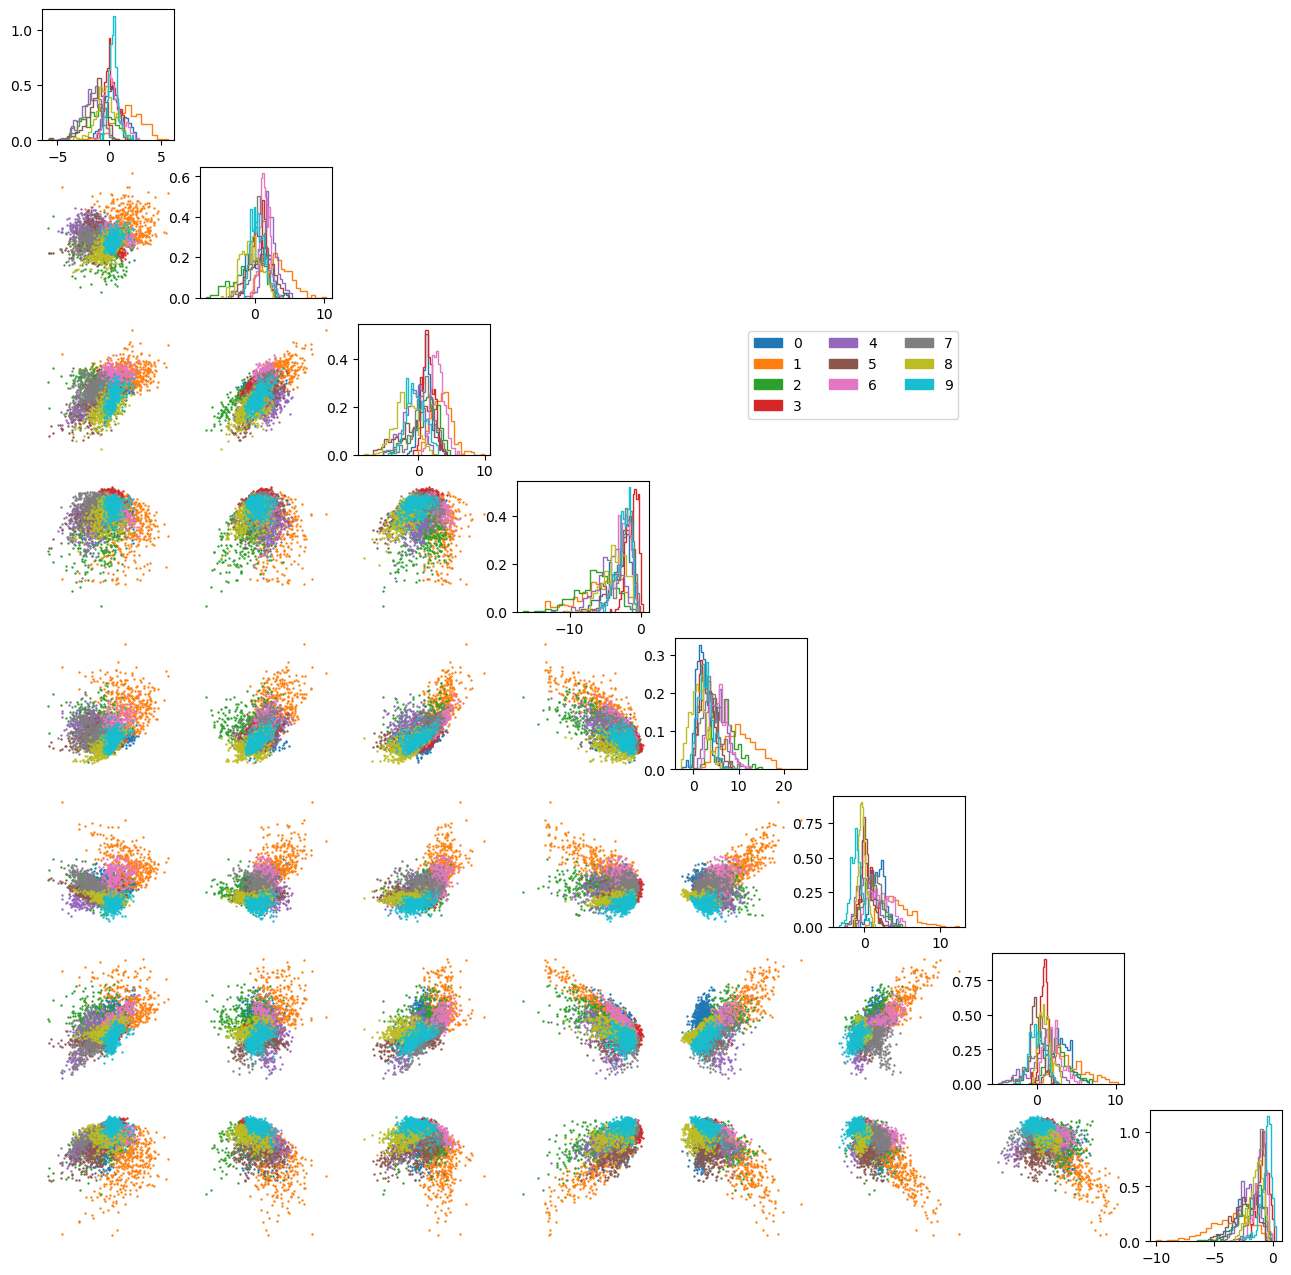

In [8]:
from plotting import make_corner
make_corner(embeds,labels)

In [9]:
# keep training
temperature = 0.1
num_epochs = 20
lr = 5e-4
total_steps = num_epochs * len(train_loader)

model.load_state_dict(best_state)
model.train()
criterion = SupervisedSimCLRLoss(device=device,temperature=temperature)
optimizer = optim.AdamW(model.parameters(), lr=lr)
#scheduler = WarmupCosineAnnealingLR(optimizer,total_steps,lr,min_lr,warmup_fraction=0.1)

100%|██████████| 19/19 [02:24<00:00,  7.62s/it]


Epoch 21, train: 4.746297723368595, val: 4.814137935638428


100%|██████████| 19/19 [02:25<00:00,  7.63s/it]


Epoch 22, train: 4.684463676653411, val: 4.696952641010284


100%|██████████| 19/19 [02:25<00:00,  7.63s/it]


Epoch 23, train: 4.65222356193944, val: 4.592092990875244


100%|██████████| 19/19 [02:25<00:00,  7.64s/it]


Epoch 24, train: 4.55011763070759, val: 4.6128809452056885


100%|██████████| 19/19 [02:24<00:00,  7.62s/it]


Epoch 25, train: 4.497036896253887, val: 4.5043665766716


100%|██████████| 19/19 [02:18<00:00,  7.28s/it]


Epoch 26, train: 4.479827793020951, val: 4.459584295749664


100%|██████████| 19/19 [02:22<00:00,  7.51s/it]


Epoch 27, train: 4.464098717037, val: 4.511690735816956


100%|██████████| 19/19 [02:24<00:00,  7.59s/it]


Epoch 28, train: 4.453580379486084, val: 4.490425527095795


100%|██████████| 19/19 [02:25<00:00,  7.64s/it]


Epoch 29, train: 4.3891410702153255, val: 4.497823715209961


100%|██████████| 19/19 [02:23<00:00,  7.55s/it]


Epoch 30, train: 4.391948085082205, val: 4.433570861816406


100%|██████████| 19/19 [02:19<00:00,  7.32s/it]


Epoch 31, train: 4.345473414973209, val: 4.422906965017319


100%|██████████| 19/19 [02:23<00:00,  7.54s/it]


Epoch 32, train: 4.338861139197099, val: 4.4011891186237335


100%|██████████| 19/19 [02:25<00:00,  7.67s/it]


Epoch 33, train: 4.374301533950002, val: 4.429710477590561


100%|██████████| 19/19 [02:21<00:00,  7.44s/it]


Epoch 34, train: 4.3230453666887785, val: 4.450948715209961


100%|██████████| 19/19 [02:19<00:00,  7.36s/it]


Epoch 35, train: 4.281756463803743, val: 4.3540938794612885


100%|██████████| 19/19 [02:24<00:00,  7.60s/it]


Epoch 36, train: 4.308392813331203, val: 4.392555803060532


100%|██████████| 19/19 [02:22<00:00,  7.48s/it]


Epoch 37, train: 4.30728366500453, val: 4.347360044717789


100%|██████████| 19/19 [02:26<00:00,  7.70s/it]


Epoch 38, train: 4.284368602853072, val: 4.376538872718811


100%|██████████| 19/19 [02:25<00:00,  7.65s/it]


Epoch 39, train: 4.300988285165084, val: 4.397259950637817


100%|██████████| 19/19 [02:23<00:00,  7.54s/it]


Epoch 40, train: 4.302208022067421, val: 4.37681382894516


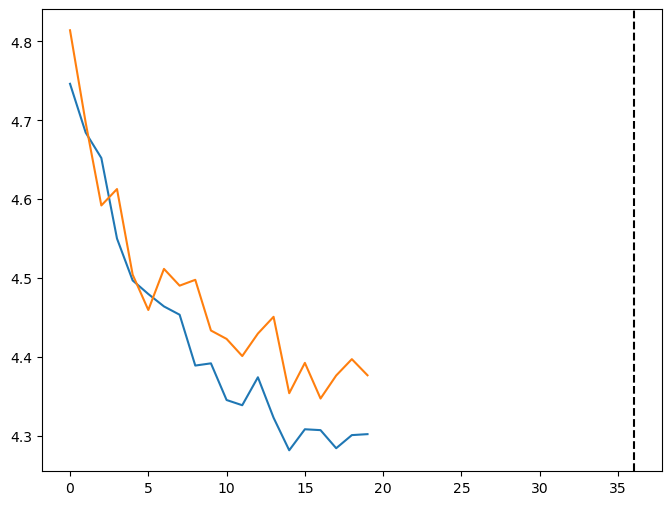

In [10]:
# Training loop
from tqdm import tqdm

losses = []
val_losses = []
best_state = None
min_loss = 9999
best_epoch = 0
global_step = 0
for epoch in range(num_epochs,2*num_epochs):
    model.train()
    epoch_loss = []
    for batch_data, labels in tqdm(train_loader):
        aug0, aug1 = batch_data
        # Forward pass
        features_0 = F.normalize(model(aug0.to(device)),dim=1).unsqueeze(1)
        features_1 = F.normalize(model(aug1.to(device)),dim=1).unsqueeze(1)
        features = torch.cat([features_0, features_1], dim=1)
        # Compute SimCLR loss
        loss = criterion(features,labels=None)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #scheduler.step()
        epoch_loss.append(loss.item())
        
        del aug0,aug1,features_0,features_1
        torch.cuda.empty_cache()
    
    mean_loss = np.mean(epoch_loss)
    losses.append(mean_loss)
    
    epoch_loss = []
    with torch.no_grad():
        for batch, labels in val_loader:
            aug0,aug1 = batch

            # Forward pass
            features_0 = F.normalize(model(aug0.to(device)),dim=1).unsqueeze(1)
            features_1 = F.normalize(model(aug1.to(device)),dim=1).unsqueeze(1)
            features = torch.cat([features_0, features_1], dim=1)

            # Compute SimCLR loss
            loss = criterion(features,labels=None)
            
            epoch_loss.append(loss.item())
            
            del aug0,aug1,features_0,features_1
            torch.cuda.empty_cache()
            
    mean_loss = np.mean(epoch_loss)
    val_losses.append(mean_loss)
    if mean_loss < min_loss:
        min_loss = mean_loss
        best_state = model.state_dict()
        best_epoch = epoch
        
    torch.save(model.state_dict,f"imagenette_fineTuned_SimCLR_Resnet50x1_epoch{epoch+1}.pt")
    
    print(f"Epoch {epoch+1}, train: {losses[-1]}, val: {val_losses[-1]}")

model.load_state_dict(best_state)
torch.save(best_state,"imagenette_fineTuned_SimCLR_Resnet50x1_best.pt")
plt.figure(figsize=(8,6))
plt.plot(np.arange(len(losses)),losses)
plt.plot(np.arange(len(val_losses)),val_losses)
plt.axvline(best_epoch,color='k',linestyle='--')

In [6]:
weights = torch.load("imagenette_fineTuned_SimCLR_Resnet50x1_best.pt")
model.load_state_dict(weights)

/tmp/ipykernel_1679301/615869525.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load("imagenette_fineTuned_SimCLR_Resnet50x1_best.pt")


<All keys matched successfully>

In [10]:
test_loader = DataLoader(test_dataset, batch_size=bs, shuffle=False, num_workers=4, pin_memory=True)

In [28]:
# compute embeddings
model = model.eval()
with torch.no_grad():
    embeds,labels = [], []
    for img,label in tqdm(test_loader):
        embeds.append(model.embed(img.to(device)).cpu().numpy())
        labels.append(label.numpy())
    embeds = np.concatenate(embeds,axis=0)
    labels = np.concatenate(labels,axis=0)

100%|██████████| 8/8 [00:09<00:00,  1.20s/it]


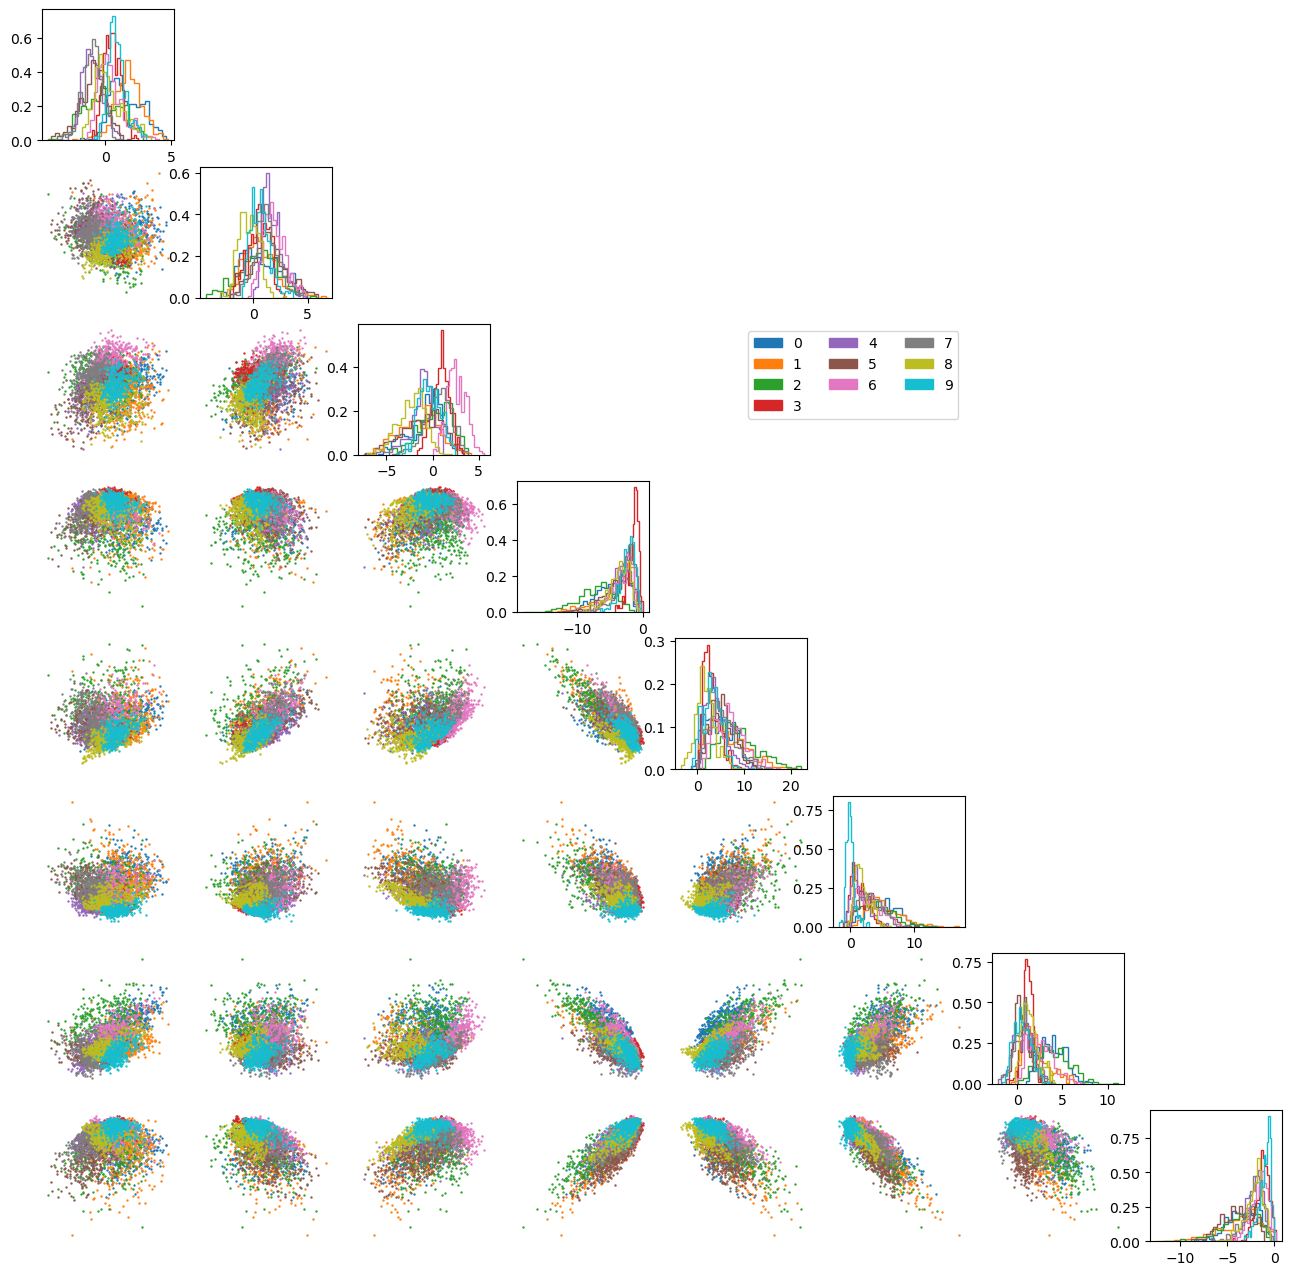

In [29]:
from plotting import make_corner
make_corner(embeds,labels)

## attempt label refinement on embeddings

In [103]:
N = embeds.shape[0]
f_labeled = 0.5

rand_idx = np.random.choice(np.arange(N),int(f_labeled*N), replace=False)
idx_sel = np.zeros(N,dtype=bool)
idx_sel[rand_idx] = True

embd_labeled = embeds[idx_sel]
labels_labeled = labels[idx_sel]

init_centroids = []
for lab in sorted(list(set(labels))):
    selected = embd_labeled[labels_labeled==lab]
    if len(selected) == 0:
        print('bad')
    else:
        init_centroids.append(selected.mean(axis=0,keepdims=True))
init_centroids = np.concatenate(init_centroids,axis=0)

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=len(set(labels)),
               init=init_centroids)
kmeans = kmeans.fit(embeds)

from plotting import make_corner
make_corner(embeds,kmeans.labels_)

In [93]:
true_agree = labels.reshape(-1,1) == labels.reshape(1,-1)
kmeans_agree = kmeans.labels_.reshape(-1,1) == kmeans.labels_.reshape(1,-1)

fig,axes = plt.subplots(1,2,figsize=(10,5))
plt.sca(axes[0])
plt.imshow(true_agree)
plt.sca(axes[1])
plt.imshow(kmeans_agree)

In [95]:
harmony = (true_agree==kmeans_agree).astype(int)
frac_agree = np.triu(harmony,1)
n = harmony.shape[0]
frac_agree.sum()/((n**2-n)/2)

0.8229381172208263

In [102]:
from sklearn.metrics import adjusted_rand_score
adjusted_rand_score(labels,kmeans.labels_)

0.12299309612694975

# just use a pretrained simclr

In [4]:
# for testing, resize to 256 along shortest dim, then center crop to 224, then normalize
# no normalization for pretrained simclr
image_width = 224
test_augment = v2.Compose([v2.PILToTensor(),
                           v2.Resize(256),
                           v2.CenterCrop(image_width),
                           v2.ToDtype(torch.float32,scale=True)])
test_dataset = Imagenette(root="/n/holystore01/LABS/iaifi_lab/Lab/sambt/neurips25/imagenette/",
                           split='val',
                           size='full',
                           download=False,
                           transform=test_augment)
test_loader = DataLoader(test_dataset,batch_size=1024,shuffle=False)

In [5]:
from resnet_wider import resnet50x1, resnet50x2, resnet50x4
weights = torch.load("/n/holystore01/LABS/iaifi_lab/Lab/sambt/neurips25/simclr_pretrained/resnet50-2x.pth")['state_dict']
model = resnet50x2()
model.load_state_dict(weights)

/tmp/ipykernel_1694680/4023543637.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load("/n/holystore01/LABS/iaifi_lab/Lab/sambt/neurips25/simclr_pretrain

<All keys matched successfully>

In [6]:
model = model.to(device)
model.eval()
with torch.no_grad():
    embeds,labels = [], []
    for img,label in tqdm(test_loader):
        embeds.append(model(img.to(device)).cpu().numpy())
        labels.append(label.numpy())
    embeds = np.concatenate(embeds,axis=0)
    labels = np.concatenate(labels,axis=0)

100%|██████████| 4/4 [00:30<00:00,  7.51s/it]


In [34]:
N = embeds.shape[0]
f_labeled = 0.01

rand_idx = np.random.choice(np.arange(N),int(f_labeled*N), replace=False)
idx_sel = np.zeros(N,dtype=bool)
idx_sel[rand_idx] = True

embd_labeled = embeds[idx_sel]
labels_labeled = labels[idx_sel]

init_centroids = []
for lab in sorted(list(set(labels))):
    selected = embd_labeled[labels_labeled==lab]
    if len(selected) == 0:
        print('bad')
    else:
        init_centroids.append(selected.mean(axis=0,keepdims=True))
init_centroids = np.concatenate(init_centroids,axis=0)

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=len(set(labels)),
               init=init_centroids)
kmeans = kmeans.fit(embeds)

frac pairwise agreement: 0.9743645182025361
rand index: 0.8587439874274386


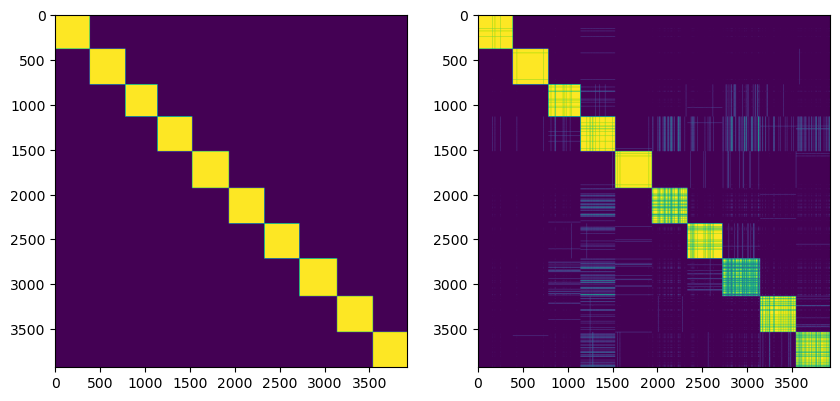

In [35]:
true_agree = labels.reshape(-1,1) == labels.reshape(1,-1)
kmeans_agree = kmeans.labels_.reshape(-1,1) == kmeans.labels_.reshape(1,-1)

fig,axes = plt.subplots(1,2,figsize=(10,5))
plt.sca(axes[0])
plt.imshow(true_agree)
plt.sca(axes[1])
plt.imshow(kmeans_agree)

harmony = (true_agree==kmeans_agree).astype(int)
frac_agree = np.triu(harmony,1)
n = harmony.shape[0]

from sklearn.metrics import adjusted_rand_score
print("frac pairwise agreement:",frac_agree.sum()/((n**2-n)/2))
print("rand index:",adjusted_rand_score(labels,kmeans.labels_))

In [36]:
from sklearn.manifold import TSNE
test = TSNE().fit_transform(embeds)

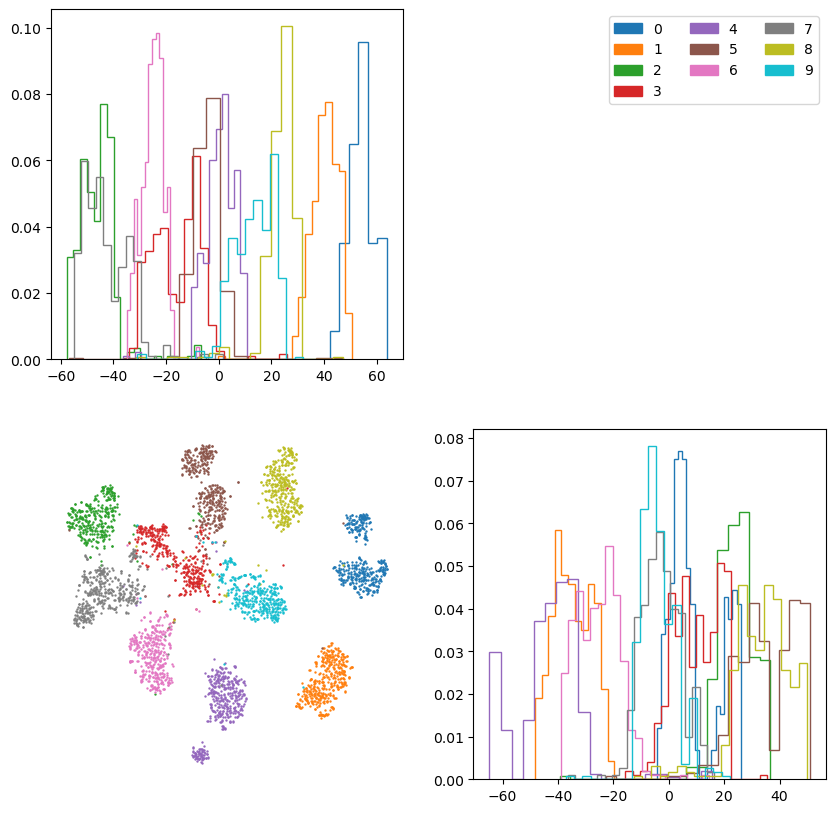

In [37]:
from plotting import make_corner
make_corner(test,labels,axwidth=5)

frac pairwise agreement: 0.9855630222637761
rand index: 0.9197701665807831


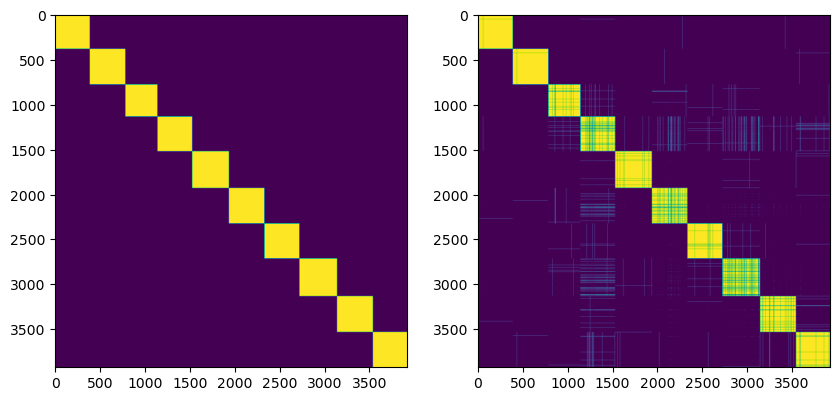

In [38]:
N = test.shape[0]
f_labeled = 0.01

rand_idx = np.random.choice(np.arange(N),int(f_labeled*N), replace=False)
idx_sel = np.zeros(N,dtype=bool)
idx_sel[rand_idx] = True

embd_labeled = test[idx_sel]
labels_labeled = labels[idx_sel]

init_centroids = []
for lab in sorted(list(set(labels))):
    selected = embd_labeled[labels_labeled==lab]
    if len(selected) == 0:
        print('bad')
    else:
        init_centroids.append(selected.mean(axis=0,keepdims=True))
init_centroids = np.concatenate(init_centroids,axis=0)

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=len(set(labels)),
               init=init_centroids)
kmeans = kmeans.fit(test)

true_agree = labels.reshape(-1,1) == labels.reshape(1,-1)
kmeans_agree = kmeans.labels_.reshape(-1,1) == kmeans.labels_.reshape(1,-1)

fig,axes = plt.subplots(1,2,figsize=(10,5))
plt.sca(axes[0])
plt.imshow(true_agree)
plt.sca(axes[1])
plt.imshow(kmeans_agree)

harmony = (true_agree==kmeans_agree).astype(int)
frac_agree = np.triu(harmony,1)
n = harmony.shape[0]

from sklearn.metrics import adjusted_rand_score
print("frac pairwise agreement:",frac_agree.sum()/((n**2-n)/2))
print("rand index:",adjusted_rand_score(labels,kmeans.labels_))

In [25]:
from sklearn.manifold import TSNE
test = TSNE(n_components=4,method='exact').fit_transform(embeds)

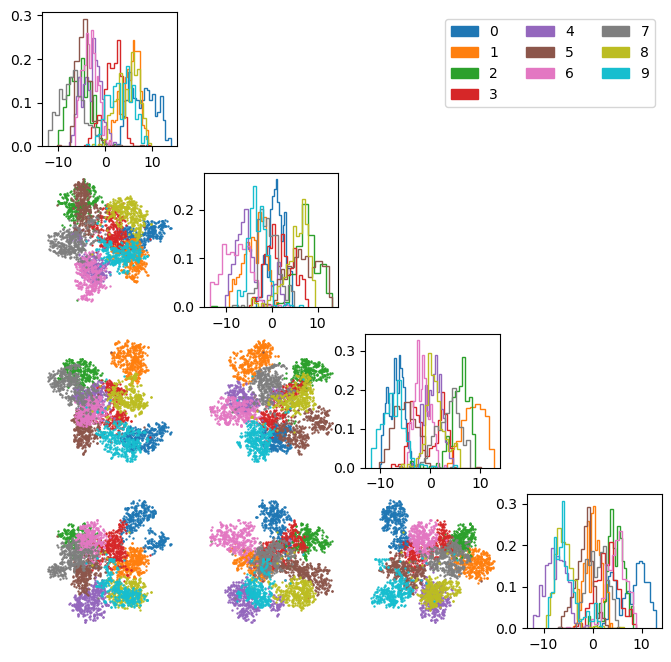

In [26]:
from plotting import make_corner
make_corner(test,labels,axwidth=2)

frac pairwise agreement: 0.9855508158190329
rand index: 0.9196449836280818


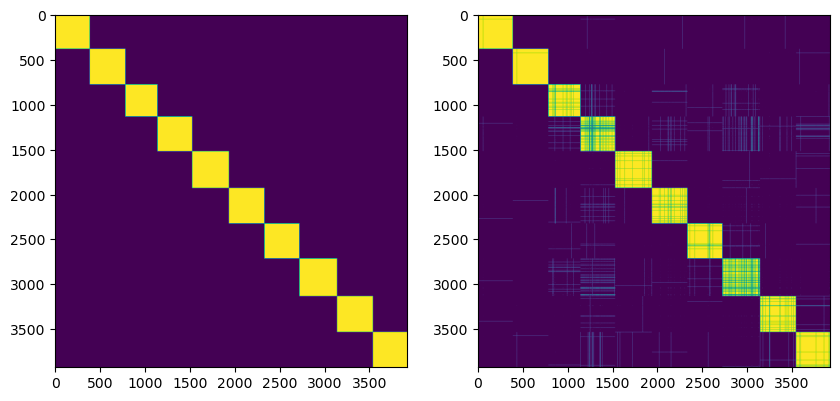

In [29]:
N = test.shape[0]
f_labeled = 0.05

rand_idx = np.random.choice(np.arange(N),int(f_labeled*N), replace=False)
idx_sel = np.zeros(N,dtype=bool)
idx_sel[rand_idx] = True

embd_labeled = test[idx_sel]
labels_labeled = labels[idx_sel]

init_centroids = []
for lab in sorted(list(set(labels))):
    selected = embd_labeled[labels_labeled==lab]
    if len(selected) == 0:
        print('bad')
    else:
        init_centroids.append(selected.mean(axis=0,keepdims=True))
init_centroids = np.concatenate(init_centroids,axis=0)

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=len(set(labels)),
               init=init_centroids)
kmeans = kmeans.fit(test)

true_agree = labels.reshape(-1,1) == labels.reshape(1,-1)
kmeans_agree = kmeans.labels_.reshape(-1,1) == kmeans.labels_.reshape(1,-1)

fig,axes = plt.subplots(1,2,figsize=(10,5))
plt.sca(axes[0])
plt.imshow(true_agree)
plt.sca(axes[1])
plt.imshow(kmeans_agree)

harmony = (true_agree==kmeans_agree).astype(int)
frac_agree = np.triu(harmony,1)
n = harmony.shape[0]

from sklearn.metrics import adjusted_rand_score
print("frac pairwise agreement:",frac_agree.sum()/((n**2-n)/2))
print("rand index:",adjusted_rand_score(labels,kmeans.labels_))